<h1>Potato Disease Classification</h1>



Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML


<h3>Set all the Constants</h3>

In [2]:

BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=50


<h2>Import data into tensorflow dataset object</h2>


We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 128, 128, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


2025-05-08 12:33:13.215936: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<h5>Visualize some of the images from our dataset</h5>

2025-05-08 12:33:13.339270: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


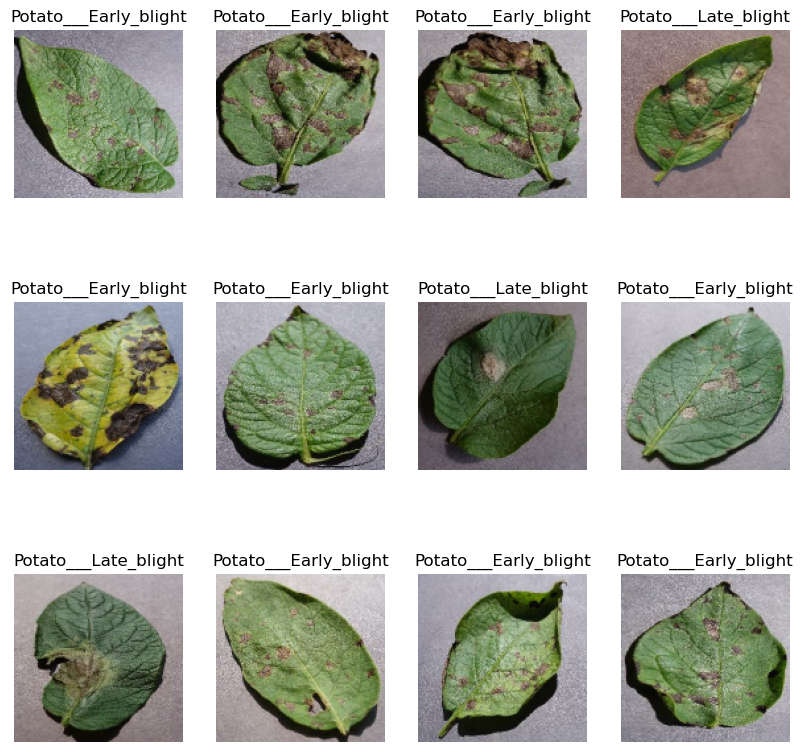

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow((image_batch[i].numpy().astype("uint8")))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")   

<h3>Function to Split Dataset</h3>
<h4>Dataset should be bifurcated into 3 subsets, namely:</h4>

1) Training: Dataset to be used while training

2) Validation: Dataset to be tested against while training

3) Test: Dataset to be tested against after we trained a model

In [7]:
len(dataset)
trainsize=0.8*len(dataset)

In [8]:

train_size = 0.8
len(dataset)*train_size


54.400000000000006

In [9]:

train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)


14

In [11]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)


6

In [13]:

test_ds = test_ds.skip(6)
len(test_ds)



8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


<h3>Cache, Shuffle, and Prefetch the Dataset</h3>

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<h2>Building the Model</h2>

<h3>Creating a Layer for Resizing and Normalization</h3>

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.


You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])


<h3>Data Augmentation</h3>
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


<h4>Applying Data Augmentation to Train Dataset</h4>

In [19]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


<h3>Model Architecture</h3>
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [20]:


input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 128, 128, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 128, 128, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 126, 126, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 63, 63, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 61, 61, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 28, 28, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 14, 14, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 25088)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,699,139 (6.48 MB)

 Trainable params: 1,699,139 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

<h3>Compiling the Model</h3>

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs= EPOCHS,
)


Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 395ms/step - accuracy: 0.5352 - loss: 0.8532 - val_accuracy: 0.7240 - val_loss: 0.7039
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 440ms/step - accuracy: 0.8519 - loss: 0.4273 - val_accuracy: 0.6562 - val_loss: 0.8474
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 574ms/step - accuracy: 0.8365 - loss: 0.4179 - val_accuracy: 0.7760 - val_loss: 0.5602
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 459ms/step - accuracy: 0.8924 - loss: 0.2658 - val_accuracy: 0.9531 - val_loss: 0.1397
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 463ms/step - accuracy: 0.8960 - loss: 0.2760 - val_accuracy: 0.8802 - val_loss: 0.2931
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 424ms/step - accuracy: 0.9462 - loss: 0.1565 - val_accuracy: 0.9531 - val_loss: 0.1677
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 440ms/step - accuracy: 0.9215 - loss: 0.1767 - val_accuracy: 0.8438 - val_loss: 0.3348
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 421ms/step - accuracy: 0.9037 - loss: 0.2165 - val_accu

In [24]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9475 - loss: 0.1364


<b>You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy</b>



In [25]:

scores


[0.14847835898399353, 0.94921875]

Scores is just a list containing loss and accuracy value

<h3>Plotting the Accuracy and Loss Curves</h3>

In [26]:
history

In [27]:
history.params

{'verbose': 'auto', 'epochs': 30, 'steps': 54}

In [28]:

history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

<b>loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch</b>



In [29]:

type(history.history['loss'])

list

In [30]:

len(history.history['loss'])

30

In [31]:
history.history['loss'][:5] # show loss for first 5 epochs


[0.726835310459137,
 0.46127283573150635,
 0.3714922368526459,
 0.2343655526638031,
 0.24119043350219727]

In [32]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


     


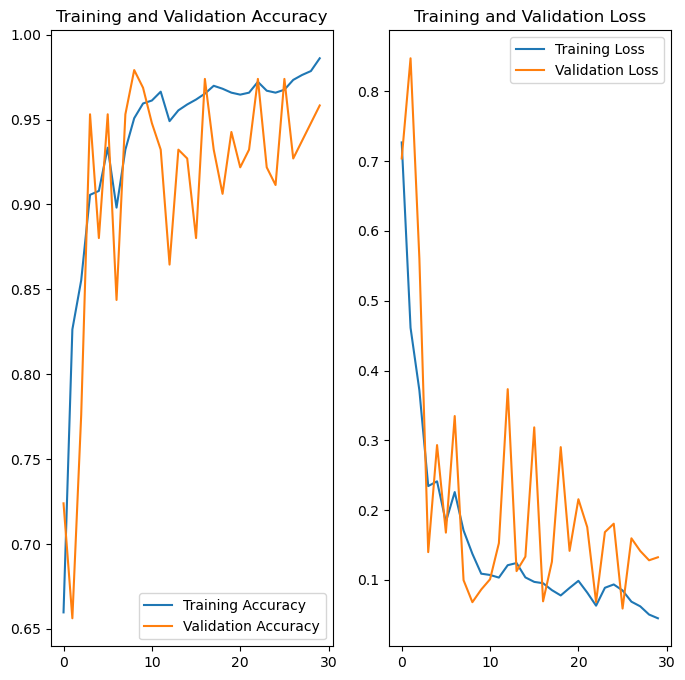

In [33]:

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


<b>Run prediction on a sample image</b>


first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
predicted label: Potato___Late_blight


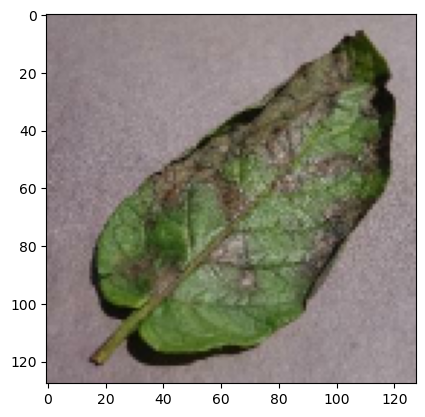

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

<h3>Write a function for inference</h3>

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


<h5>Now run inference on few sample images</h5>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2025-05-08 12:45:21.236086: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


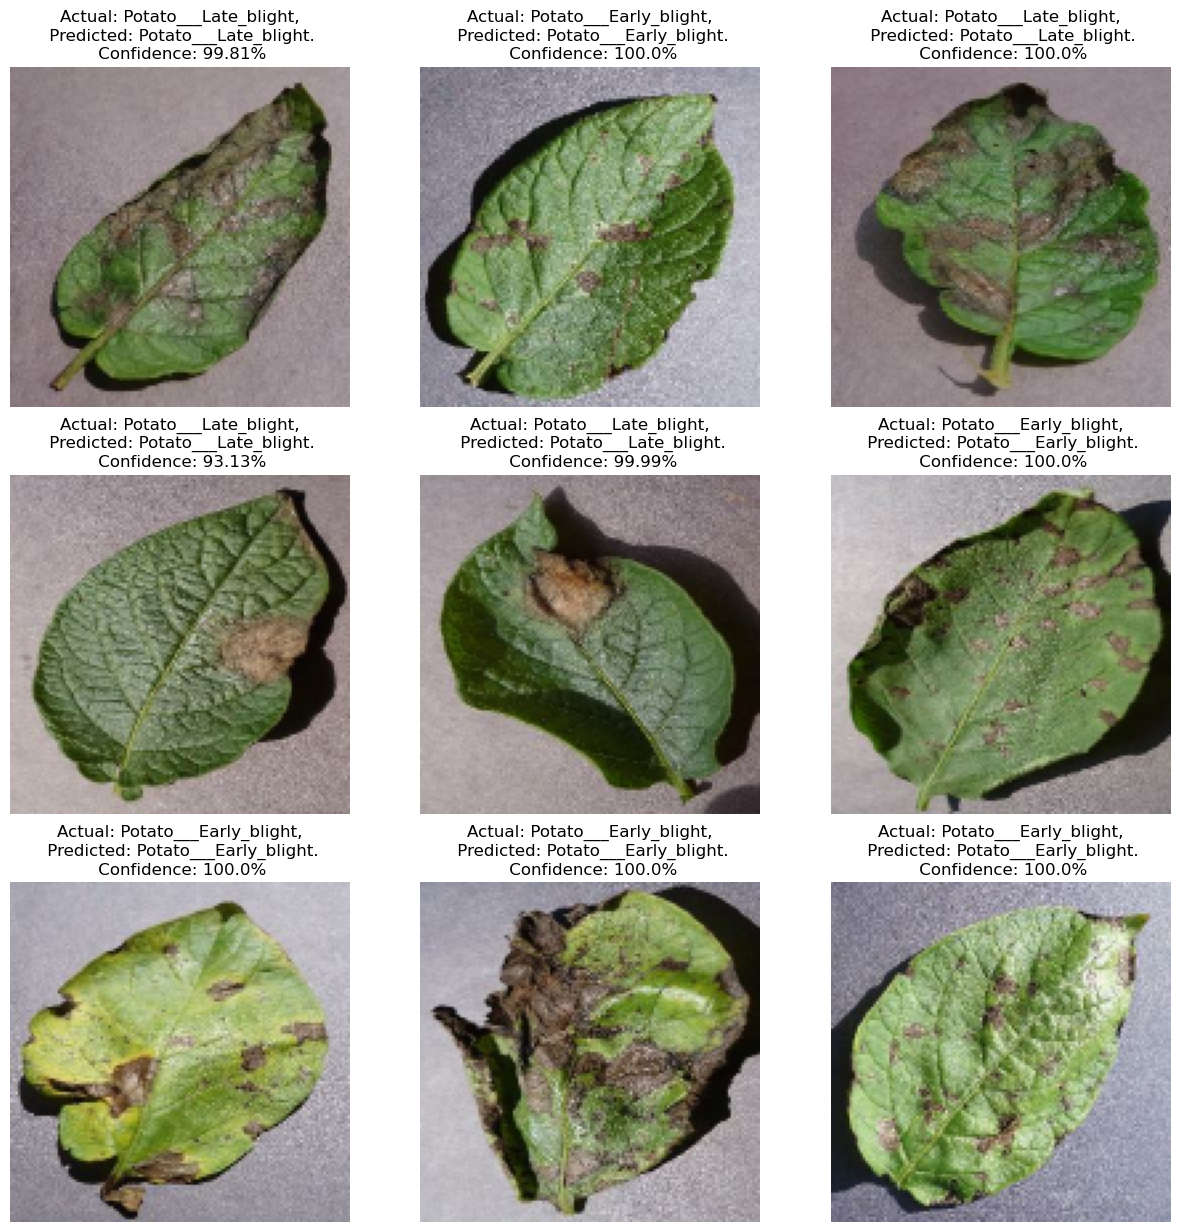

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

<h3>Saving the Model</h3>

We append the model to the list of models as a new version

In [37]:
import os

# Define the model save directory
model_dir = os.path.join(os.getcwd(), "models")
os.makedirs(model_dir, exist_ok=True)  # Create models/ if it doesn't exist

# Get the next model version number
existing_versions = [int(f.split('.')[0]) for f in os.listdir(model_dir) if f.split('.')[0].isdigit()]
model_version = max(existing_versions + [0]) + 1

# Define the full save path with .keras extension
save_path = os.path.join(model_dir, f"{model_version}.keras")

# Save the model
model.save(save_path)

print(f"Model saved to: {save_path}")


Model saved to: /Users/Keertan_Surendhra/Desktop/Data Science/Vegetable_ Dataset/models/3.keras


In [38]:
import os
print(os.getcwd())

/Users/Keertan_Surendhra/Desktop/Data Science/Vegetable_ Dataset


In [39]:
from tensorflow import keras

model = keras.models.load_model("models/2.keras")


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [40]:
import os

print(os.path.exists("models/2.keras"))  


True
